In [1]:
"""
Created on Mon Jul 21 17:41:36 2025

@author: kennyaskelson
"""

'\nCreated on Mon Jul 21 17:41:36 2025\n\n@author: kennyaskelson\n'

In preparation for an interview at a position focused on fraud detection
I worked on a practice data set from kaggle https://www.kaggle.com/competitions/ieee-fraud-detection/overview
to demonstrate my ability to investigate complex datasets and build a xgboost model to detect fraud.

This dataset was a tricky one! There are over 400 features and +500,000 examples, with a high degree of missing data and class imbalance (fraud class < 3%).
Another challenge is that the features have no or very poor metadata, so I felt reluctant to use feature engineering.
Instead I focused mostly on feature selection using missing data filters and dropping highly correlated features.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost 

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
import statsmodels.api as sm
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from imblearn.combine import SMOTETomek
from sklearn.impute import KNNImputer

Read in datasets. 

In [4]:
df_trans = pd.read_csv('train_transaction.csv')

In [5]:
df_iden = pd.read_csv('train_identity.csv')

left merge two datasets on TransactionID

In [6]:
merged_transaction_df = pd.merge(df_trans, df_iden, on='TransactionID', how='left')

split data based on fraud or not fraud, and plot transaction amounts

In [7]:
df_trans_fraud = merged_transaction_df[merged_transaction_df['isFraud'] == 1]

In [8]:
df_trans_not_fraud = merged_transaction_df[merged_transaction_df['isFraud'] == 0]

(0.0, 2000.0)

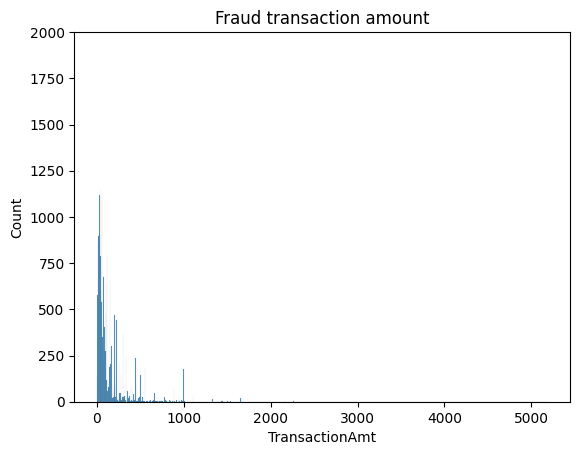

In [9]:
sns.histplot(data=df_trans_fraud, x='TransactionAmt', bins=1000).set_title("Fraud transaction amount")
plt.ylim(0, 2000)

(0.0, 2000.0)

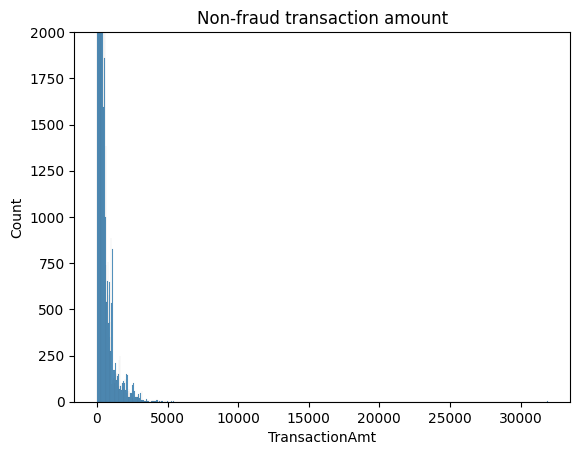

In [10]:
sns.histplot(data=df_trans_not_fraud, x='TransactionAmt', bins=1000).set_title("Non-fraud transaction amount")
plt.ylim(0, 2000)

Ok, the data is hard to visualize with a histogram, but 
most transactions are small and we have a few very large transactions.
A violin plot of log transaction values will be more helpful here.

In [11]:
merged_transaction_df['TransAmtLog'] = np.log(merged_transaction_df['TransactionAmt'])

[Text(0.5, 1.0, 'Fraud and non-fraud log(transaction amount)'),
 Text(0.5, 0, 'Fraud Category'),
 Text(0, 0.5, 'log(transaction amount)')]

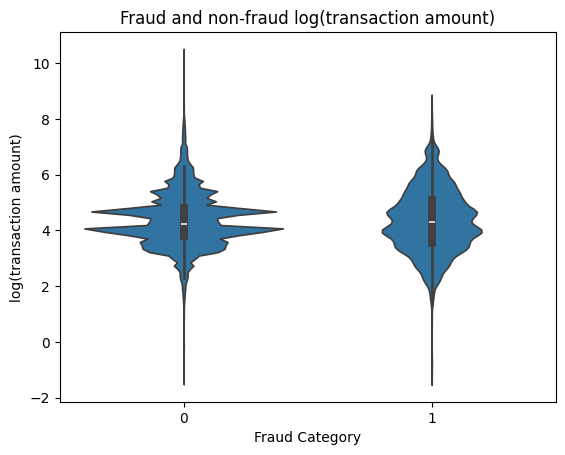

In [12]:
sns.violinplot(data=merged_transaction_df, x="isFraud", y="TransAmtLog").set(title = "Fraud and non-fraud log(transaction amount)", xlabel="Fraud Category", ylabel="log(transaction amount)")

The distributions are similar, with fraud being a bit higher and lacking extreme outliers.
Non-fraudulent charges have a much higher occurence of ~ 4.1 and ~4.9 (log value; eye balling) transaction amounts. 

To convert back to raw dollar amount 

In [13]:
np.exp(4.1)

np.float64(60.34028759736195)

60.34

In [14]:
np.exp(4.9)

np.float64(134.28977968493552)

134.29

During my literature review, I learned of an interesting way to look for fraud by using Benfords law (https://en.wikipedia.org/wiki/Benford%27s_law),
which states that in sets of real numbers, the first digit of those numbers will disproportionally be one. 

In this function, we convert numbers to strings, get the first number and convert back to an integer
If, it is less than 1, we multiply by 100 (so we don't grab 0). 

In [14]:
def getfirstdigit(digits):
    first_num = []
    for i in range(len(digits)):
        if digits[i] > 1:
            first_num.append(int(str(digits[i])[0]))
        if digits[i] < 1:
            dig_100 = digits[i] * 100
            first_num.append(int(str(dig_100)[0]))
    return first_num

In [15]:
first_digits_fraud = pd.DataFrame(getfirstdigit(df_trans_fraud['TransactionAmt'].tolist()), columns=['digit'])

In [16]:
first_digits_not_fraud = pd.DataFrame(getfirstdigit(df_trans_not_fraud['TransactionAmt'].tolist()), columns=['digit'])

Text(0.5, 1.0, 'Distribution of First Digit Fraud')

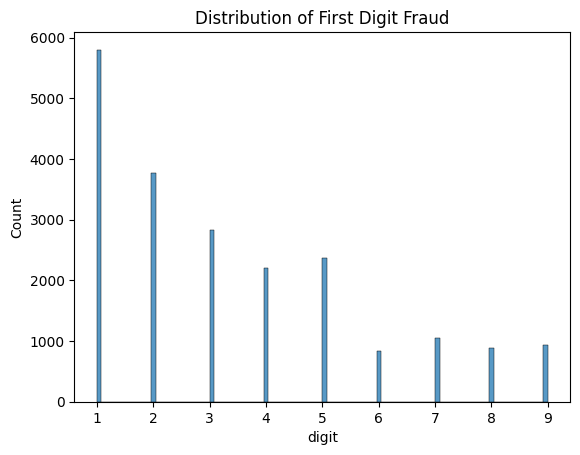

In [17]:
sns.histplot(data=first_digits_fraud, x='digit', bins=100).set_title("Distribution of First Digit Fraud")

Text(0.5, 1.0, 'Distribution of First Digit Non-fraud')

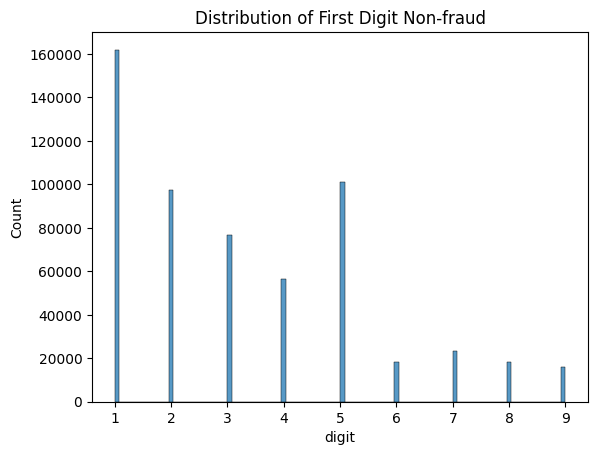

In [18]:
sns.histplot(data=first_digits_not_fraud, x='digit', bins=100).set_title("Distribution of First Digit Non-fraud")

In [19]:
category_proportions_not_fraud = first_digits_not_fraud['digit'].value_counts(normalize=True)
print(category_proportions_not_fraud)

digit
1    0.284244
5    0.177431
2    0.171228
3    0.134889
4    0.098990
7    0.041190
6    0.032183
8    0.031821
9    0.028024
Name: proportion, dtype: float64


In [20]:
category_proportions_fraud = first_digits_fraud['digit'].value_counts(normalize=True)
print(category_proportions_fraud)

digit
1    0.280854
2    0.182412
3    0.136628
5    0.114365
4    0.106330
7    0.050528
9    0.045155
8    0.043171
6    0.040558
Name: proportion, dtype: float64


Both fraud categories seem similar and mostly follow Benfords law. This makes sense as both sets are "real numbers" in that they are real transactions. I think this method could be used if fraudsters were picking numbers to look "random" to hide the fraudlent activity. 

Now lets look at missing data across our features

In [21]:
missing_data = []

In [22]:
for col in merged_transaction_df.columns:
    missing_fraction = merged_transaction_df[col].isna().sum() / len(merged_transaction_df)
    missing_data.append([col, missing_fraction])

In [23]:
missing_data_df = pd.DataFrame(missing_data, columns=['column', 'missing_fraction'])

Text(0.5, 1.0, 'Missing % in features')

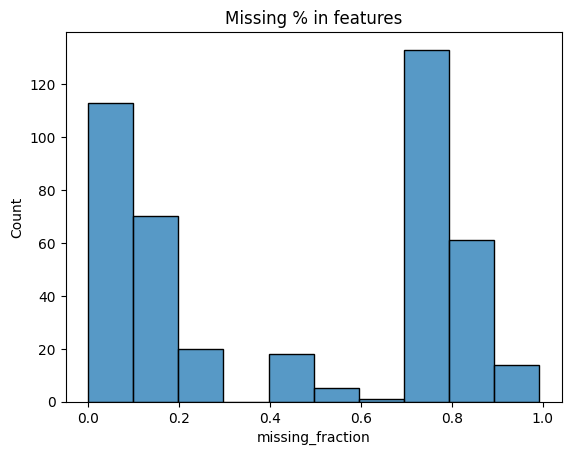

In [24]:
sns.histplot(data=missing_data_df, x='missing_fraction', bins=10).set_title("Missing % in features")

In [62]:
merged_transaction_df_cleaned = merged_transaction_df.copy()

Drop log-value feature otherwise it throws an error

In [63]:
merged_transaction_df_cleaned.drop(columns='TransAmtLog', inplace=True)

In [64]:
threshold = 0.5  # If over this in fraud or non-fraud the feature is dropped

In [65]:
for col in merged_transaction_df_cleaned.columns:
    missing_fraction_not_fraud = df_trans_not_fraud[col].isna().sum() / len(df_trans_not_fraud)
    missing_fraction_fraud = df_trans_fraud[col].isna().sum() / len(df_trans_fraud)
    if missing_fraction_not_fraud > threshold:
        merged_transaction_df_cleaned.drop(columns=col, inplace=True)
    elif missing_fraction_fraud > threshold:
        merged_transaction_df_cleaned.drop(columns=col, inplace=True)

This leaves us with 202 features.

Now lets find the categorical columns, to convert them to numeric.

In [66]:
cols = merged_transaction_df_cleaned.columns

In [67]:
num_cols = merged_transaction_df_cleaned._get_numeric_data().columns

In [68]:
list(set(cols) - set(num_cols))

['card4', 'card6', 'P_emaildomain', 'M4', 'ProductCD']

In [44]:
cats = list(set(cols) - set(num_cols))

In [45]:
for col in cats:
    print(merged_transaction_df_cleaned[col].unique())

['discover' 'mastercard' 'visa' 'american express' nan]
['credit' 'debit' nan 'debit or credit' 'charge card']
[nan 'gmail.com' 'outlook.com' 'yahoo.com' 'mail.com' 'anonymous.com'
 'hotmail.com' 'verizon.net' 'aol.com' 'me.com' 'comcast.net'
 'optonline.net' 'cox.net' 'charter.net' 'rocketmail.com' 'prodigy.net.mx'
 'embarqmail.com' 'icloud.com' 'live.com.mx' 'gmail' 'live.com' 'att.net'
 'juno.com' 'ymail.com' 'sbcglobal.net' 'bellsouth.net' 'msn.com' 'q.com'
 'yahoo.com.mx' 'centurylink.net' 'servicios-ta.com' 'earthlink.net'
 'hotmail.es' 'cfl.rr.com' 'roadrunner.com' 'netzero.net' 'gmx.de'
 'suddenlink.net' 'frontiernet.net' 'windstream.net' 'frontier.com'
 'outlook.es' 'mac.com' 'netzero.com' 'aim.com' 'web.de' 'twc.com'
 'cableone.net' 'yahoo.fr' 'yahoo.de' 'yahoo.es' 'sc.rr.com' 'ptd.net'
 'live.fr' 'yahoo.co.uk' 'hotmail.fr' 'hotmail.de' 'hotmail.co.uk'
 'protonmail.com' 'yahoo.co.jp']
['M2' 'M0' nan 'M1']
['W' 'H' 'C' 'S' 'R']


These are categorical features we need to convert to numeric. 
Below I set manual values, there is probably an easier way to do this but there is only 5 columns, so for simplicity I approached it like this.

In [69]:
for col in merged_transaction_df_cleaned.columns:
    unique_vals = set(merged_transaction_df_cleaned[col][merged_transaction_df_cleaned[col].notna()].unique())  # drop NaNs to avoid false negatives
    if set(unique_vals) <= {'credit', 'debit', 'charge card','debit or credit'}:
        merged_transaction_df_cleaned[col] = merged_transaction_df_cleaned[col].map({'credit': 1, 'debit': 0, 'charge card': 2, 'debit or credit':3})

In [70]:
for col in merged_transaction_df_cleaned.columns:
    unique_vals = set(merged_transaction_df_cleaned[col][merged_transaction_df_cleaned[col].notna()].unique())   # drop NaNs to avoid false negatives
    if set(unique_vals) <= {'visa', 'mastercard', 'discover','american express'}:
        merged_transaction_df_cleaned[col] = merged_transaction_df_cleaned[col].map({'visa': 1, 'mastercard': 0, 'discover': 2, 'american express': 3})

In [71]:
for col in merged_transaction_df_cleaned.columns:
    unique_vals = set(merged_transaction_df_cleaned[col][merged_transaction_df_cleaned[col].notna()].unique())   # drop NaNs to avoid false negatives
    if set(unique_vals) <= {'M0','M2','M1'}:
        merged_transaction_df_cleaned[col] = merged_transaction_df_cleaned[col].map({'M1': 1, 'M0': 0, 'M2': 2}) 

In [72]:
for col in merged_transaction_df_cleaned.columns:
    unique_vals = set(merged_transaction_df_cleaned[col][merged_transaction_df_cleaned[col].notna()].unique())   # drop NaNs to avoid false negatives
    if set(unique_vals) <= {'W', 'C', 'R', 'S', 'H'}:
        merged_transaction_df_cleaned[col] = merged_transaction_df_cleaned[col].map({'W': 1, 'C': 0, 'R': 2, 'S': 3, 'H': 4}) 

Now we need to convert email domains.

In [73]:
domains = merged_transaction_df_cleaned['P_emaildomain'].unique()

remove nan category.

In [74]:
domains = domains[1:]

In [75]:
# Convert to a pandas Series
series = pd.Series(domains)

In [76]:
# If you want to see the mapping:
label_mapping = {label: code for code, label in enumerate(series.astype("category").cat.categories)}

In [77]:
label_mapping

{'aim.com': 0,
 'anonymous.com': 1,
 'aol.com': 2,
 'att.net': 3,
 'bellsouth.net': 4,
 'cableone.net': 5,
 'centurylink.net': 6,
 'cfl.rr.com': 7,
 'charter.net': 8,
 'comcast.net': 9,
 'cox.net': 10,
 'earthlink.net': 11,
 'embarqmail.com': 12,
 'frontier.com': 13,
 'frontiernet.net': 14,
 'gmail': 15,
 'gmail.com': 16,
 'gmx.de': 17,
 'hotmail.co.uk': 18,
 'hotmail.com': 19,
 'hotmail.de': 20,
 'hotmail.es': 21,
 'hotmail.fr': 22,
 'icloud.com': 23,
 'juno.com': 24,
 'live.com': 25,
 'live.com.mx': 26,
 'live.fr': 27,
 'mac.com': 28,
 'mail.com': 29,
 'me.com': 30,
 'msn.com': 31,
 'netzero.com': 32,
 'netzero.net': 33,
 'optonline.net': 34,
 'outlook.com': 35,
 'outlook.es': 36,
 'prodigy.net.mx': 37,
 'protonmail.com': 38,
 'ptd.net': 39,
 'q.com': 40,
 'roadrunner.com': 41,
 'rocketmail.com': 42,
 'sbcglobal.net': 43,
 'sc.rr.com': 44,
 'servicios-ta.com': 45,
 'suddenlink.net': 46,
 'twc.com': 47,
 'verizon.net': 48,
 'web.de': 49,
 'windstream.net': 50,
 'yahoo.co.jp': 51,
 'ya

Convert to numeric 

In [78]:
merged_transaction_df_cleaned['P_emaildomain'] = merged_transaction_df_cleaned['P_emaildomain'].map(label_mapping)

Ok now we have converted all our categorical features to numeric, lets see if we can drop some these
anonymous "V" features.

get a list of V columns 

In [79]:
v_columns = [col for col in merged_transaction_df_cleaned.columns if col.startswith("V")]

In [80]:
just_Vs = merged_transaction_df_cleaned[v_columns]

In [81]:
V_corr = just_Vs.corr()

Now we have correlation, lets convert to R^2 to show the variation explained between the two V columns compared.

In [82]:
V_R2 = (V_corr)**2

In [83]:
np.fill_diagonal(V_R2.values, 0)

Text(0.5, 1.0, 'R^2 values between V columns in dataset')

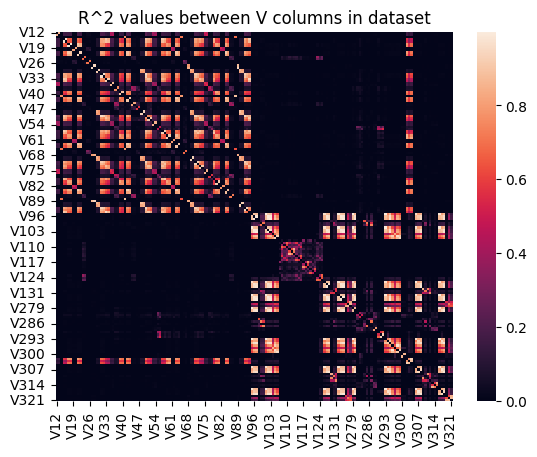

In [84]:
sns.heatmap(V_R2).set_title("R^2 values between V columns in dataset")

There is a lot of correlation between various V features. 

Lets filter high R^2 out of the dataset

first fill in diagonal (self correlation always 1).

In [85]:
# Create mask for upper triangle
upper = np.triu(np.ones(V_R2.shape), k=1).astype(bool)
upper_corr = V_R2.where(upper)

In [86]:
# Set threshold (0.5 means one V columns explains 50% of the variation in another V column)
threshold = 0.5

In [87]:
# Find column pairs with correlation above the threshold
to_drop = set()

In [88]:
for col in upper_corr.columns:
    for row in upper_corr.index:
        if upper_corr.loc[row, col] > threshold:
            # Randomly drop one of the two
            drop_col = np.random.choice([row, col])
            to_drop.add(drop_col)

In [89]:
# Drop selected columns
reduced_df = merged_transaction_df_cleaned.drop(columns=to_drop)

After removing correlated features we have just 68 features!

Lets see the heatmap after cleaning.

In [90]:
v_columns = [col for col in reduced_df.columns if col.startswith("V")]

In [91]:
just_Vs = merged_transaction_df_cleaned[v_columns]

In [92]:
V_corr = just_Vs.corr()

get R^2

In [93]:
V_R2 = (V_corr)**2

In [94]:
np.fill_diagonal(V_R2.values, 0)

Text(0.5, 1.0, 'R^2 values between V columns after cleaning')

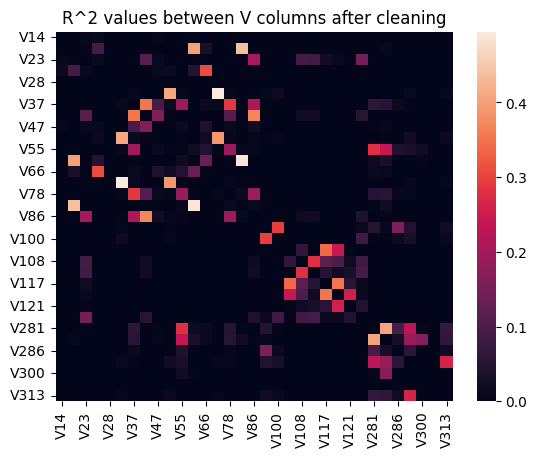

In [95]:
sns.heatmap(V_R2).set_title("R^2 values between V columns after cleaning")

Looks a lot better!

For the first model we can leave missing as 'nan', as xgboost handles this.

In [96]:
X = reduced_df.drop(columns = ['isFraud', 'TransactionID'])       # Features
y = reduced_df['isFraud']     # Labels

In [97]:
# 3. Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

In [98]:
# create model instance
best_model = XGBClassifier(scale_pos_weight=8, objective='binary:logistic', n_estimators=300, max_depth=10, learning_rate=0.2, gamma= 0,
                    colsample_bytree=1.0, subsample=0.7, reg_lambda=1)
# fit model
best_model.fit(X_train, y_train)
# make predictions
test_predictions = best_model.predict(X_test)
print("Best Accuracy:", accuracy_score(y_test, test_predictions))
print("Classification Report:\n", classification_report(y_test, test_predictions))

Best Accuracy: 0.9876158544157325
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    170821
           1       0.89      0.74      0.81      6341

    accuracy                           0.99    177162
   macro avg       0.94      0.87      0.90    177162
weighted avg       0.99      0.99      0.99    177162



I commented out the hyperparameter tuning, to prevent running it again in the jupyter notebook

xgb = XGBClassifier(use_label_encoder=False, eval_metric='error')

param_dist = {
   'scale_pos_weight': [2, 4, 6, 8],
   'n_estimators': [50, 100, 200, 300],
   'max_depth': [3, 5, 7, 10, 15],
   'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
   'subsample': [0.1, 0.2, 0.5, 0.7, 1.0],
   'colsample_bytree': [0.6, 0.8, 1.0],
   'gamma': [0, 0.1, 0.2, 1.0],
   'reg_lambda': [0, 1, 2, 5, 10],
}

random_search = RandomizedSearchCV(
   estimator=xgb,
   param_distributions=param_dist,
   n_iter=200,  # Increase for a more thorough search
   scoring='f1',
   cv=5,
   verbose=1,
   random_state=42,
   n_jobs=-1
)

random_search.fit(X_train, y_train.values.ravel()) 

best_model = random_search.best_estimator_
test_predictions = best_model.predict(X_test)
print("Best Accuracy:", accuracy_score(y_test, test_predictions))
print("Classification Report:\n", classification_report(y_test, test_predictions))
print(random_search.best_params_)
{'subsample': 0.7, 'scale_pos_weight': 8, 'reg_lambda': 1, 'n_estimators': 300, 'max_depth': 10, 'learning_rate': 0.2, 'gamma': 0, 'colsample_bytree': 1.0}

Best Accuracy: 0.9873674941578894
Classification Report:
              precision    recall  f1-score   support

          0       0.99      1.00      0.99    170821
          1       0.89      0.74      0.81      6341

  accuracy                           0.99    177162
  macro avg       0.94      0.87      0.90    177162
weighted avg       0.99      0.99      0.99    177162

### Lets now look at ROC curve. ######

No Skill: ROC AUC=0.500
xgboost: ROC AUC=0.967


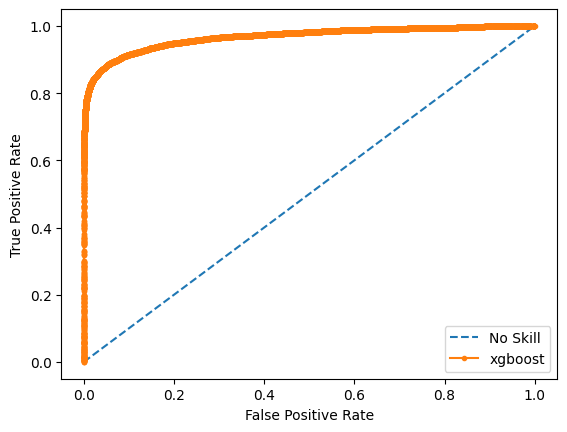

In [99]:
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
xgb_probs = best_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('xgboost: ROC AUC=%.3f' % (xgb_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='xgboost')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
#xgboost: ROC AUC=0.966

In [104]:
### Now lets look at PR curve. #####

xgb: f1=0.811 auc=0.848


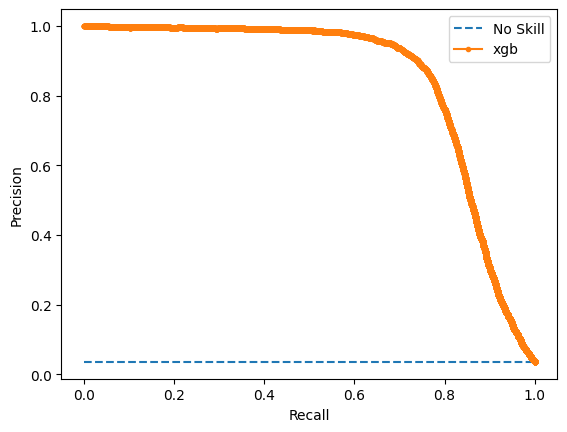

In [120]:
xgb_probs = best_model.predict_proba(X_test)
# keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:, 1]
# predict class values
yhat = best_model.predict(X_test)
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test, xgb_probs)
xgb_f1, xgb_auc = f1_score(y_test, yhat), auc(xgb_recall, xgb_precision)
# summarize scores
print('xgb: f1=%.3f auc=%.3f' % (xgb_f1, xgb_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(xgb_recall, xgb_precision, marker='.', label='xgb')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()
#xgb: f1=0.811 auc=0.845

#### ok now lets try SMOTEtomek #####

SMOTEtomek will over sample our minority class by generating synthetic data and then removing majority class examples that overlap with the newly generated data.

SMOTEtomek links doesn't tolerate missing data so we need to fill it in, for this we will use median values.

I tried missing data imputation using KNN imputer to have imputation based on neighbors rather than a data wide median, this takes a long
time to run so not practical on huge datasets and it didn't improve the model. 

In [106]:
reduced_smotek = reduced_df.copy()

In [107]:
for col in reduced_smotek.columns:
    median_value = reduced_smotek[col].median()
    reduced_smotek[col] = reduced_smotek[col].fillna(median_value)

In [108]:
#sanity check it's filled in 
reduced_smotek.columns[reduced_smotek.isna().any()].tolist()

[]

In [109]:
X_smotek = reduced_smotek.drop(columns = ['isFraud', 'TransactionID'])       # Features
y_smotek = reduced_smotek['isFraud']     # Labels

In [110]:
# 3. Split data into training and testing sets
X_train_smotek, X_test_smotek, y_train_smotek, y_test_smotek = train_test_split(X_smotek, y_smotek, test_size=0.3, random_state=42, shuffle=True)

In [111]:
# this will over sample minority by creating synthetic data k nearest neighbors and then use tomek links to clean up overlap between minority and majority classes in cluster space 
smotetomek = SMOTETomek(random_state=0, sampling_strategy='not majority', n_jobs=4)

In [112]:
X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(X_train_smotek, y_train_smotek)

[Text(0.5, 1.0, 'Observation counts after SMOTEtomek'),
 Text(0.5, 0, 'Fraud Category'),
 Text(0, 0.5, 'Counts')]

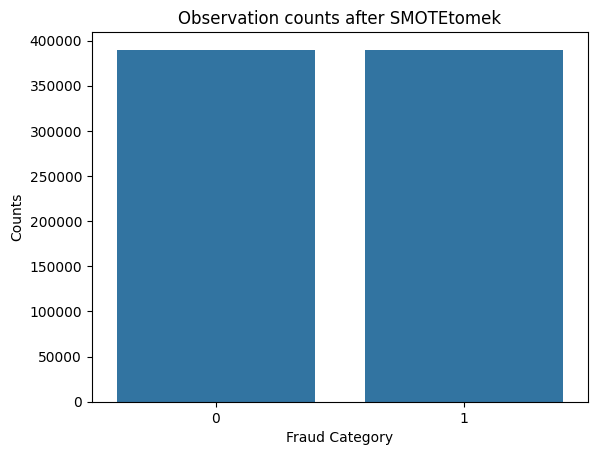

In [115]:
# Create a count plot
sns.countplot(x='isFraud', data=pd.DataFrame(y_train_smotetomek)).set(title = "Observation counts after SMOTEtomek", xlabel="Fraud Category", ylabel="Counts")

Now we have equal counts of fraud and non-fraud! cool!

In [116]:
best_model_smotetomek = XGBClassifier(objective='binary:logistic', n_estimators=300, max_depth=15, learning_rate=0.05, gamma= 0.1,
                    colsample_bytree=1.0, subsample=0.7, reg_lambda=1)
# fit model
best_model_smotetomek.fit(X_train_smotetomek, y_train_smotetomek)
# make predictions
test_predictions = best_model_smotetomek.predict(X_test_smotek)
print("Best Accuracy:", accuracy_score(y_test_smotek, test_predictions))
print("Classification Report:\n", classification_report(y_test_smotek, test_predictions))

Best Accuracy: 0.9853467447872568
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    170821
           1       0.93      0.64      0.76      6341

    accuracy                           0.99    177162
   macro avg       0.96      0.82      0.88    177162
weighted avg       0.98      0.99      0.98    177162



I commented out the hyperparameter tuning, to prevent running it again in the jupyter notebook

xgb_smote = XGBClassifier(use_label_encoder=False, eval_metric='error')

param_dist = {
   'n_estimators': [50, 100, 200, 300],
   'max_depth': [3, 5, 7, 10, 15],
   'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3],
   'subsample': [0.1, 0.2, 0.5, 0.7, 1.0],
   'colsample_bytree': [0.6, 0.8, 1.0],
   'gamma': [0, 0.1, 0.2, 1.0],
   'reg_lambda': [0, 1, 2, 5, 10],
}

random_search_smotetomek = RandomizedSearchCV(
   estimator=xgb_smote,
   param_distributions=param_dist,
   n_iter=200,  # Increase for a more thorough search
   scoring='f1',
   cv=5,
   verbose=1,
   random_state=42,
   n_jobs=-1
)

random_search_smotetomek.fit(X_train_smotetomek, y_train_smotetomek.values.ravel()) 

best_model_smotetomek = random_search_smotetomek.best_estimator_
test_predictions_smotetomek = best_model_smotetomek.predict(X_test_smotek)
print("Best Accuracy:", accuracy_score(y_test_smotek, test_predictions_smotetomek))
print("Classification Report:\n", classification_report(y_test_smotek, test_predictions_smotetomek))
print(random_search_smotetomek.best_params_)
{'subsample': 0.7, 'reg_lambda': 1, 'n_estimators': 300, 'max_depth': 15, 'learning_rate': 0.05, 'gamma': 0.1, 'colsample_bytree': 1.0}

Best Accuracy: 0.9846468204242445
Classification Report:
              precision    recall  f1-score   support

          0       0.99      1.00      0.99    170821
          1       0.93      0.62      0.74      6341

   accuracy                           0.98    177162
  macro avg       0.96      0.81      0.87    177162
weighted avg       0.98      0.98      0.98    177162

### look at ROC curve ######

No Skill: ROC AUC=0.500
xgboost: ROC AUC=0.968


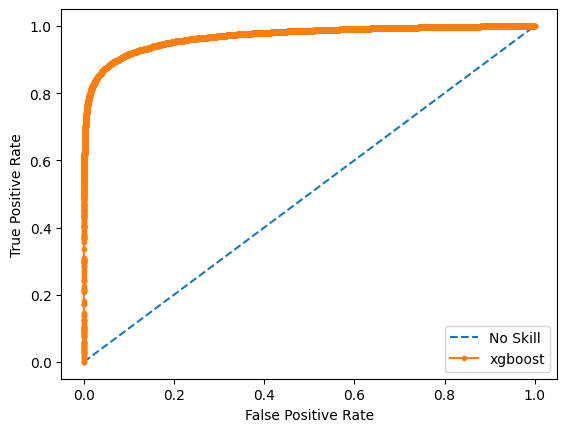

In [117]:
ns_probs = [0 for _ in range(len(y_test_smotek))]
# predict probabilities
xgb_probs = best_model_smotetomek.predict_proba(X_test_smotek)
# keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test_smotek, ns_probs)
xgb_auc = roc_auc_score(y_test_smotek, xgb_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('xgboost: ROC AUC=%.3f' % (xgb_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test_smotek, ns_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test_smotek, xgb_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='xgboost')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

xgboost: ROC AUC=0.967

xgb: f1=0.758 auc=0.830


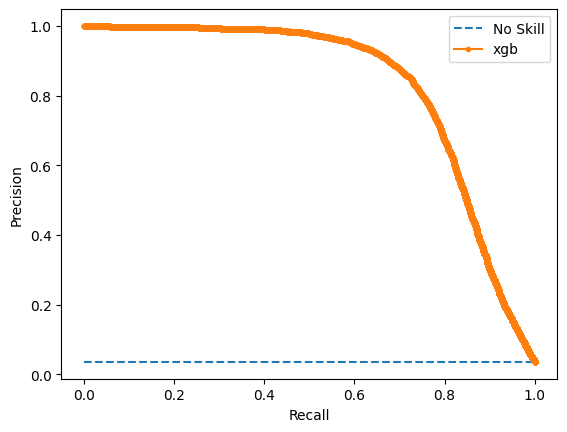

In [119]:
### look at PR curve #####
xgb_probs = best_model_smotetomek.predict_proba(X_test_smotek)
# keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:, 1]
# predict class values
yhat = best_model_smotetomek.predict(X_test_smotek)
xgb_precision, xgb_recall, _ = precision_recall_curve(y_test_smotek, xgb_probs)
xgb_f1, xgb_auc = f1_score(y_test_smotek, yhat), auc(xgb_recall, xgb_precision)
# summarize scores
print('xgb: f1=%.3f auc=%.3f' % (xgb_f1, xgb_auc))
# plot the precision-recall curves
no_skill = len(y_test_smotek[y_test_smotek==1]) / len(y_test_smotek)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(xgb_recall, xgb_precision, marker='.', label='xgb')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()
#xgb: f1=0.758 auc=0.830

Cool! This was fun to try but looks like this model is slightly worse.
Overall I think this is a decent model for not having really any information on the features and no feature engineering.